In [15]:
%matplotlib inline

import os
import astropy

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
from radvel.plot import orbit_plots, mcmc_plots

## Stellar and Planetary system info

In [16]:
# TOI 663

Mstar= 0.5 # 0.51      #in Solar masses

Mplanet1= 20. # 5.78   #in Earth masses 
period1 = 20. # 2.598654   #in days
e1 = 0.1 # 0.0         #unitless
tp1 = 0 # 1544.390641   #JD - 2457000  [TESS epochs]
om1 = 0.5 * np.pi # 270.0/180.0*np.pi

# Mplanet2= 6.255   #in Earth masses
# period2 = 4.698465   #in days
# e2 = 0.0         #unitless
# tp2 = 1543.394099   #JD - 2457000  [TESS epochs]
# om2 = 270.0/180.0*np.pi

# Mplanet3= 4.469   #in Earth masses 
# period3 = 7.102747   #in days
# e3 = 0.0         #unitless
# tp3 = 1547.110793   #JD - 2457000  [TESS epochs]
# om3 = 270.0/180.0*np.pi


#Calculate resulting RV semi-amplitude in m/s
rvk1=radvel.utils.semi_amplitude(Mplanet1, period1, Mstar, e1, Msini_units='earth')
# rvk2=radvel.utils.semi_amplitude(Mplanet2, period2, Mstar, e2, Msini_units='earth')
# rvk3=radvel.utils.semi_amplitude(Mplanet3, period3, Mstar, e3, Msini_units='earth')

print('predicted RV semi-amplitudes (m/s): ',rvk1) # ,rvk2,rvk3)

#Create RADVEL input orbital element arrays
orbel1 = np.array([period1, tp1, e1, om1, rvk1])  
# orbel2 = np.array([period2, tp2, e2, om2, rvk2])
# orbel3 = np.array([period3, tp3, e3, om3, rvk3])

predicted RV semi-amplitudes (m/s):  7.517052535221021


## Convert stellar info into exposure time and RV precision

In [17]:
# get homemade rv curve
with open("rv_lc.csv",) as f:
    homemade = np.loadtxt(f,delimiter="," )
my_time = homemade[:,0]

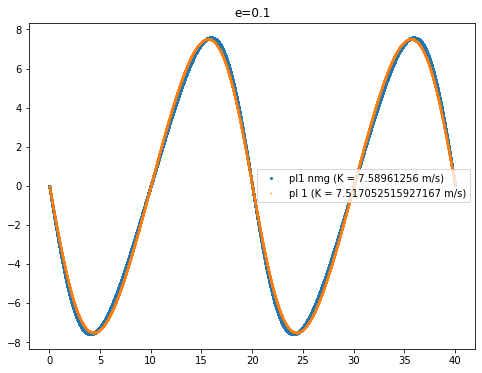

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

# plot the orbit to make sure the amplitude, period, and eccentricity look correct
jd0 = np.linspace(tp1, tp1+40, num=20000)
rv1 = radvel.kepler.rv_drive(jd0, orbel1)
# rv2 = radvel.kepler.rv_drive(jd0, orbel2)
# rv3 = radvel.kepler.rv_drive(jd0, orbel3)

# plot homemade rv curve of pl1
ax.plot(jd0, homemade[:,1], '.', ms=4, 
         label=f'pl1 nmg (K = {np.abs(homemade[:,1]).max()} m/s)')

#Plot RV signal of planet 1
ax.plot(jd0, rv1, '.', ms=1, 
        label=f'pl 1 (K = {np.abs(rv1).max()} m/s)')

# #Plot RV signal of planet 2
# plt.plot(jd0, rv2, '.', label='pl 2')

# #Plot RV signal of planet 3
# plt.plot(jd0, rv3, '.', label='pl 3')

##Plot Combined RV signals of all three planets
##plt.plot(jd0, rv1, '.', label='all')  # rv1+rv2+rv3

plt.legend()
plt.title(f"e={e1}")
plt.savefig("e_0.1_compare.png")

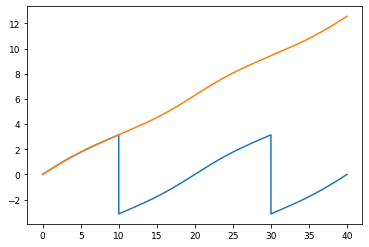

In [12]:
# compare true anomaly (omega (+ Omega) + theta)
true_anom_1 = radvel.orbit.true_anomaly(jd0, tp1, period1, e1)
plt.plot(jd0, true_anom_1)
plt.plot(my_time, homemade[:,2])

Text(0.5, 1.0, 'my time - radvel time')

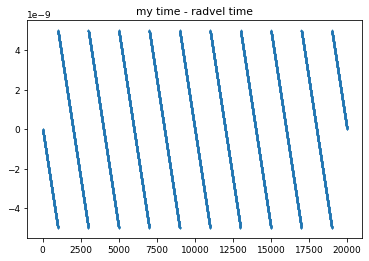

In [13]:
t_diff = homemade[:,0] - jd0
plt.plot(t_diff, '.', ms=1)
plt.title("my time - radvel time")

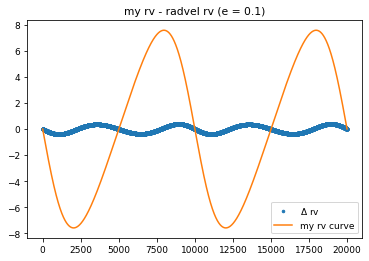

In [14]:
rv_diff = (homemade[:,1] - rv1 )
plt.plot(rv_diff, '.', label=r"$\Delta~$rv")
plt.plot(homemade[:,1], label="my rv curve")
plt.title("my rv - radvel rv (e = 0.1)")
plt.legend(loc='lower right')

## Set the various error parameters for the data set

In [19]:
sigma_phot = 1.7   # RV photon uncertainty [m/s]
sigma_floor = 0.5  # RV instrument floor [m/s]
sigma_jit = 0.5    # Stellar jitter term [m/s]
sigma_all = np.sqrt(sigma_phot**2 + sigma_floor**2 + sigma_jit**2) # Add all unc. terms in quadrature

## Telescope coverage info

In [20]:
# MAROON-X coverage, assume nightly observations throughout March 2022 and half of April 2022

year = [2022]
month = [3,4]
day = [[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]

from datetime import datetime

jd = np.array([])

for yr in year:
  for imon, mon in enumerate(month):
    for da in day[imon]:
      t = astropy.time.Time(datetime(yr,mon,da,0,0,0), scale='utc')    
      jd = np.append(jd, t.jd)

#Add some randomization around the observation times, so it's not always at exactly the same minute of the night
jd_scatter=np.random.normal(0,.08,jd.shape)
jd += jd_scatter
jd -= 2457000.0

## Quick check on how those simulated observations look on top of the RV model

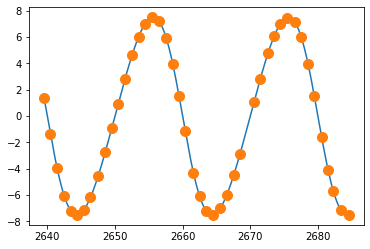

In [22]:
# Coverage map for 1 planet (formerly 3 planet case)

jd0 = np.linspace(min(jd), max(jd), num=5000)
rv1_0 = radvel.kepler.rv_drive(jd0, orbel1)
# rv2_0 = radvel.kepler.rv_drive(jd0, orbel2)
# rv3_0 = radvel.kepler.rv_drive(jd0, orbel3)
rv0 = rv1_0 # +rv2_0+rv3_0

plt.plot(jd0, rv0, '-')
rv1 = radvel.kepler.rv_drive(jd, orbel1)
# rv2 = radvel.kepler.rv_drive(jd, orbel2)
# rv3 = radvel.kepler.rv_drive(jd, orbel3)
plt.plot(jd, rv1, 'o', markersize=10) # rv1+rv2+rv3

## Simulate RVs based on noise & observing dates

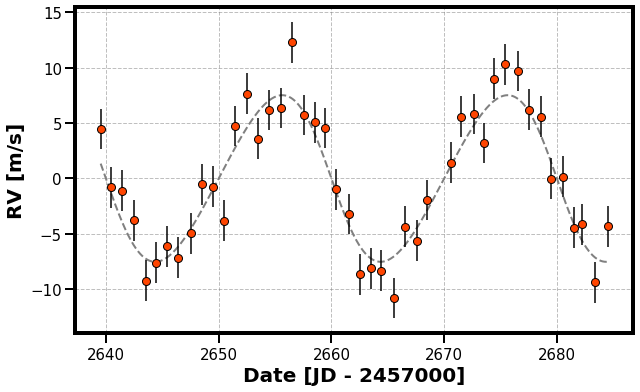

In [23]:
# Make a copy of the noise-less RV dataset to use as the model
rv = rv1 # +rv2+rv3

# Now add noise to it according to sigma_all
res = np.random.normal(scale=sigma_all, size=len(rv))
rv += res  

#Plot the model RV curve and the simulated RV observations
fig = plt.figure(1,[10,6])
ax1 = fig.add_subplot(111)

ax1.grid(color='grey', linestyle='--', linewidth=1,alpha=.5)
ax1.plot(jd0, rv0,color='grey',linestyle='--',markersize=2,zorder=1,linewidth=2)
ax1.errorbar(jd, rv, yerr=sigma_all, xerr=None, color='orangered', markeredgecolor='black',ecolor='black',marker='o',ls='None',capsize=0, markersize=8,zorder=2)

ax1.tick_params(axis='both',which='both',labelsize=15,direction='out',length=10,width=2)
#ax1.tick_params(axis='x',which='minor',labelsize=8,direction='out',length=6,width=2)
ax1.set_ylabel('RV [m/s]',fontsize=20,fontweight='bold')
ax1.set_xlabel('Date [JD - 2457000]',fontsize=20,fontweight='bold')

plt.setp(ax1.spines.values(), linewidth=4)

plt.show()

err = np.zeros(len(rv))+sigma_all

## Print out the RV time series

In [24]:
for i in range(0,len(jd)):
    print(jd[i]+2457000,rv[i],sigma_all)

2459639.534490942 4.458705155733118 1.841195263952197
2459640.468374503 -0.7869792792488112 1.841195263952197
2459641.455890534 -1.0905176020670067 1.841195263952197
2459642.5217188485 -3.784010628420461 1.841195263952197
2459643.5103706634 -9.213152241560197 1.841195263952197
2459644.4483371535 -7.597187422171164 1.841195263952197
2459645.396075414 -6.126320415367732 1.841195263952197
2459646.3810019665 -7.16364442488766 1.841195263952197
2459647.528247183 -4.947928629037135 1.841195263952197
2459648.553581763 -0.5221615803640836 1.841195263952197
2459649.5203795526 -0.7382021080119723 1.841195263952197
2459650.4865176263 -3.8152753543653306 1.841195263952197
2459651.462517339 4.731842427097328 1.841195263952197
2459652.5404593605 7.659910823191662 1.841195263952197
2459653.50984889 3.607515169663967 1.841195263952197
2459654.47037027 6.179346953839568 1.841195263952197
2459655.497543485 6.3542705596225595 1.841195263952197
2459656.5062559913 12.283036468819564 1.841195263952197
24596

## Plot the RVs phase folded to each planet's orbit

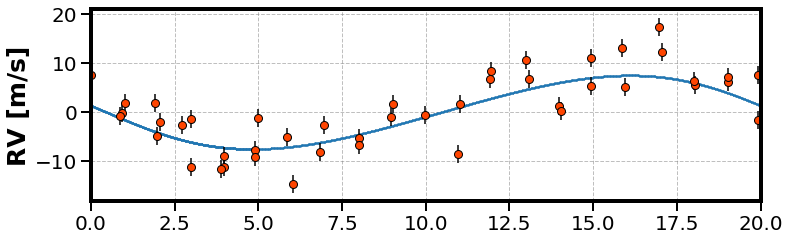

In [25]:
fig = plt.figure(1,[12,12])

#m = RV model, p = planet data
phase1m = (jd0-min(jd0))/period1 - np.floor((jd0-min(jd0))/period1) 
phase1p = (jd-min(jd))/period1 - np.floor((jd-min(jd))/period1)

ax1 = fig.add_subplot(311)
ax1.grid(color='grey', linestyle='--', linewidth=1,alpha=.5)
ax1.plot(phase1m*period1, rv1_0,'.',markersize=1)
ax1.errorbar(phase1p*period1, rv1+res, yerr=sigma_all, xerr=None, color='orangered', markeredgecolor='black',ecolor='black',marker='o',ls='None',capsize=0, markersize=8,zorder=2)
ax1.set_xlim([0,period1])
ax1.set_ylabel('RV [m/s]',fontsize=25,fontweight='bold')
ax1.tick_params(axis='both',which='both',labelsize=20,direction='out',length=10,width=2)


# phase2m = (jd0-min(jd0))/period2 - np.floor((jd0-min(jd0))/period2) 
# phase2p = (jd-min(jd))/period2 - np.floor((jd-min(jd))/period2)

# ax2 = fig.add_subplot(312)
# ax2.grid(color='grey', linestyle='--', linewidth=1,alpha=.5)
# ax2.plot(phase2m*period2, rv2_0, '.',markersize=1)
# ax2.errorbar(phase2p*period2, rv2+res, yerr=sigma_all, xerr=None, color='orangered', markeredgecolor='black',ecolor='black',marker='o',ls='None',capsize=0, markersize=8,zorder=2)
# ax2.set_xlim([0,period2])
# ax2.set_ylabel('RV [m/s]',fontsize=25,fontweight='bold')
# ax2.set_xlabel('Orbital Phase [days]',fontsize=25,fontweight='bold')
# ax2.tick_params(axis='both',which='both',labelsize=20,direction='out',length=10,width=2)

# phase3m = (jd0-min(jd0))/period3 - np.floor((jd0-min(jd0))/period3) 
# phase3p = (jd-min(jd))/period3 - np.floor((jd-min(jd))/period3)

# ax3 = fig.add_subplot(313)
# ax3.grid(color='grey', linestyle='--', linewidth=1,alpha=.5)
# ax3.plot(phase3m*period3, rv3_0, '.',markersize=1)
# ax3.errorbar(phase3p*period3, rv3+res, yerr=sigma_all, xerr=None, color='orangered', markeredgecolor='black',ecolor='black',marker='o',ls='None',capsize=0, markersize=8,zorder=2)
# ax3.set_xlim([0,period3])
# ax3.set_ylabel('RV [m/s]',fontsize=25,fontweight='bold')
# ax3.set_xlabel('Orbital Phase [days]',fontsize=25,fontweight='bold')
# ax3.tick_params(axis='both',which='both',labelsize=20,direction='out',length=10,width=2)

plt.setp(ax1.spines.values(), linewidth=4)
# plt.setp(ax2.spines.values(), linewidth=4)
# plt.setp(ax3.spines.values(), linewidth=4)

plt.show()

## Predict planet mass constraints based on coverage and precision

Use RADVEL to fit the orbit and see what kind of constraint the data have put on K

In [50]:
matplotlib.rcParams['font.size'] = 14

# initial guesses
def initialize_model():
    time_base = 2457000
    params = radvel.Parameters(0,basis='per tp e w k')  #(2,basis='per tp e w k')
    params['per1'] = radvel.Parameter(value=period1)
    params['tp1'] = radvel.Parameter(value=tp1)
    params['e1'] = radvel.Parameter(value=e1)
    params['w1'] = radvel.Parameter(value=om1)
    params['k1'] = radvel.Parameter(value=rvk1)
    
#     params['per2'] = radvel.Parameter(value=period2)
#     params['tp2'] = radvel.Parameter(value=tp2)
#     params['e2'] = radvel.Parameter(value=e2)
#     params['w2'] = radvel.Parameter(value=om2)
#     params['k2'] = radvel.Parameter(value=rvk2)

#     params['per3'] = radvel.Parameter(value=period3)
#     params['tp3'] = radvel.Parameter(value=tp3)
#     params['e3'] = radvel.Parameter(value=e3)
#     params['w3'] = radvel.Parameter(value=om3)
#     params['k3'] = radvel.Parameter(value=rvk3)

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=0)
    mod.params['curv'] = radvel.Parameter(value=0)
    return mod

In [51]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, jd, rv, err)
like.params['gamma'] = radvel.Parameter(value=0.1)
like.params['jit'] = radvel.Parameter(value=0.5)

like.params['tc1'] = radvel.Parameter(value=tp1)
# like.params['tc2'] = radvel.Parameter(value=tp2)
# like.params['tc3'] = radvel.Parameter(value=tp3)

like.params['k1'] = radvel.Parameter(value=rvk1)
# like.params['k2'] = radvel.Parameter(value=rvk2)
# like.params['k3'] = radvel.Parameter(value=rvk3)


like.params['e1'].vary = False
like.params['w1'].vary = False
like.params['per1'].vary = False
like.params['tp1'].vary = False

# like.params['e2'].vary = False
# like.params['w2'].vary = False
# like.params['per2'].vary = False
# like.params['tp2'].vary = False

# like.params['e3'].vary = False
# like.params['w3'].vary = False
# like.params['per3'].vary = False
# like.params['tp3'].vary = False

like.params['dvdt'].vary = False
like.params['curv'].vary = False

print(like)

parameter                     value      vary
per1                             20      False
tp1                               0      False
e1                              0.1      False
w1                           1.5708      False
k1                          7.51705       True
dvdt                              0      False
curv                              0      False
gamma                           0.1       True
jit                             0.5       True
tc1                               0       True



In [52]:
# Convert parameters to a different basis
oldbasis = radvel.basis.Basis('per tp e w k', 1) #3)
newparams = oldbasis.from_synth(like.params, 'per tc secosw sesinw logk',keep=False)

time_base = 2457000.0
mod = radvel.RVModel(newparams, time_base=time_base)

like = radvel.likelihood.RVLikelihood(mod, jd, rv, err)

In [53]:
like.params['gamma'] = radvel.Parameter(value=0.1)
like.params['jit'] = radvel.Parameter(value=1.0)

like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False
like.params['per1'].vary = False
like.params['tc1'].vary = False

# like.params['secosw2'].vary = False
# like.params['sesinw2'].vary = False
# like.params['per2'].vary = False
# like.params['tc2'].vary = False

# like.params['secosw3'].vary = False
# like.params['sesinw3'].vary = False
# like.params['per3'].vary = False
# like.params['tc3'].vary = False

like.params['dvdt'] = radvel.Parameter(value=0.0)
like.params['curv'] = radvel.Parameter(value=0.0)
like.params['dvdt'].vary = False
like.params['curv'].vary = False

#like.params['logk1'] = radvel.Parameter(value=np.log(rvk1))
#like.params['logk1'].vary = True

# like.params['logk2'] = radvel.Parameter(value=np.log(rvk2))
# like.params['logk2'].vary = True

# like.params['logk3'] = radvel.Parameter(value=np.log(rvk3))
# like.params['logk3'].vary = True

print(like)

parameter                     value      vary
per1                             20      False
dvdt                              0      False
curv                              0      False
gamma                           0.1       True
jit                               1       True
tc1                               0      False
secosw1                 1.93634e-17      False
sesinw1                    0.316228      False
logk1                       2.01717       True
tp1                               0           
e1                              0.1           
w1                           1.5708           
k1                          7.51705           



In [63]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.Gaussian( 'jit', np.log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk1', np.log(rvk1), 10)]
# post.priors += [radvel.prior.Gaussian( 'logk2', np.log(rvk2), 10)]
# post.priors += [radvel.prior.Gaussian( 'logk3', np.log(rvk3), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

In [62]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

print(post)

KeyError: 'logk1'

In [40]:
df = radvel.mcmc(post,nwalkers=20,nrun=30000, serial=True)

emcee: Exception while calling your likelihood function:
  params: [0.10902315 1.07748803]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/natalia.guerrero/miniconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/natalia.guerrero/miniconda3/lib/python3.8/site-packages/radvel/posterior.py", line 64, in logprob_array
    _logprob = self.logprob()
  File "/Users/natalia.guerrero/miniconda3/lib/python3.8/site-packages/radvel/posterior.py", line 49, in logprob
    _logprob += prior(self.params, self.vector)
  File "/Users/natalia.guerrero/miniconda3/lib/python3.8/site-packages/radvel/prior.py", line 34, in __call__
    x = vector.vector[vector.indices[self.param]][0]
KeyError: 'logk1'


KeyError: 'logk1'

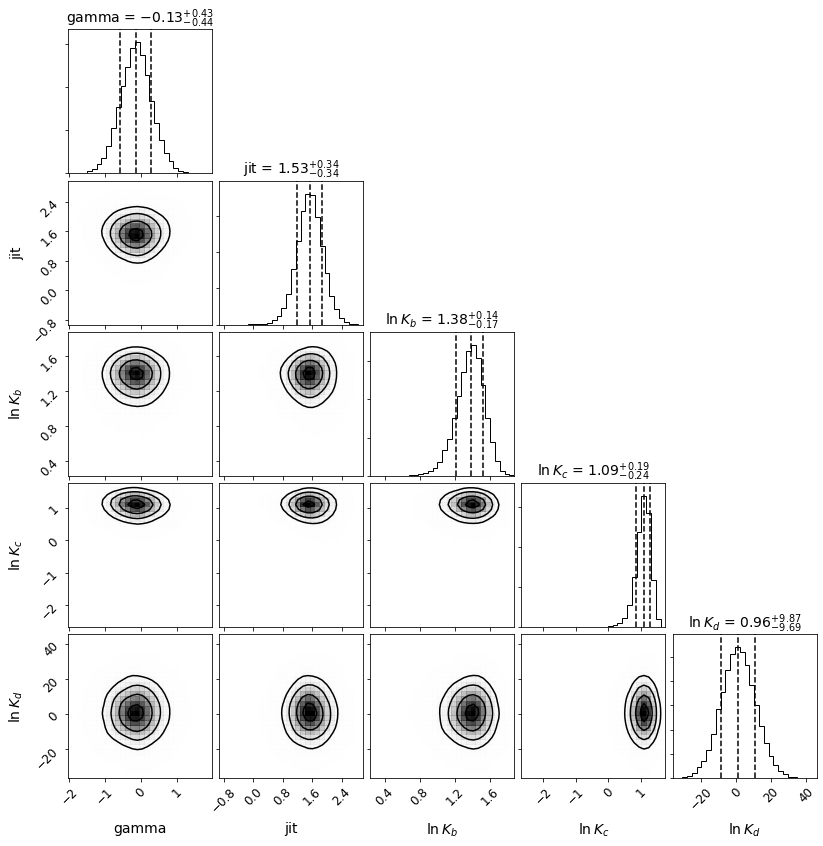

In [26]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fd9295e46d0>])

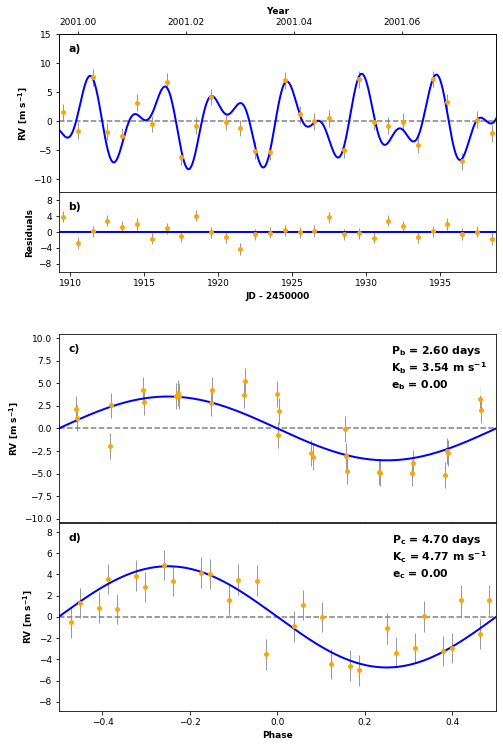

In [131]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False, nobin=True)
RVPlot.plot_multipanel()